In [2]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [3]:
light_2019 = read_merged('lightning', 2019)

In [4]:
del light_2019['#ZDAY']
del light_2019['Unnamed: 0']

In [5]:
light_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493781 entries, 0 to 2493780
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   CENTERLON     float64
 1   CENTERLAT     float64
 2   TOTAL_COUNT   int64  
 3   DATE          object 
 4   county        object 
 5   state         object 
 6   power_outage  bool   
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 116.5+ MB


In [6]:
light_2019['log_total_count'] = np.log10(light_2019['TOTAL_COUNT'])
light_2019['DATE'] = pd.to_datetime(light_2019['DATE'])
light_2019['Month'] = light_2019['DATE'].dt.month

In [26]:
light_2019.columns

Index(['CENTERLON', 'CENTERLAT', 'TOTAL_COUNT', 'DATE', 'county', 'state',
       'power_outage', 'log_total_count', 'Month'],
      dtype='object')

In [18]:
light_2019['power_outage'].value_counts(normalize=True)

False    0.980163
True     0.019837
Name: power_outage, dtype: float64

### Let's try XGBOOST

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer


In [8]:
light_train, light_test = train_test_split(light_2019.copy(), shuffle=True, test_size=0.2, stratify=light_2019.power_outage)

In [32]:
xgb_clas1 = xgboost.XGBClassifier(learning_rate=.1,
                                   max_depth=3,
                                   n_estimators=200, objective='binary:logistic')

In [28]:
features = ['CENTERLON', 'CENTERLAT', 'log_total_count', 'Month', 'TOTAL_COUNT']

In [33]:
xgb_clas1.fit(light_train[features],light_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
pred = xgb_clas1.predict(light_train[features])
acc, prec, recall = accuracy_score(pred, light_train.power_outage), precision_score(pred, light_train.power_outage), recall_score(pred, light_train.power_outage)

In [14]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (14, 16,  1),
    'n_estimators': range(300, 380, 20),
    'learning_rate': [0.25, 0.35]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)


In [15]:
grid_search.fit(light_train[features],light_train['power_outage'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/painchess/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.25, 0.35],
                         'max_depth': range(14, 16),
                         'n_estimators': range(300, 380, 20)},
             scoring='f1', verbose=True)

In [17]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.35, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [16]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.25, 14, 300): 0.2857932269483647,
 (0.25, 14, 320): 0.28781746197011815,
 (0.25, 14, 340): 0.28768882580160365,
 (0.25, 14, 360): 0.28699956266677995,
 (0.25, 15, 300): 0.2880848635984533,
 (0.25, 15, 320): 0.2874323866628078,
 (0.25, 15, 340): 0.2874634334101201,
 (0.25, 15, 360): 0.28750286100023736,
 (0.35, 14, 300): 0.28877211261110314,
 (0.35, 14, 320): 0.2886573734693859,
 (0.35, 14, 340): 0.28832402840806853,
 (0.35, 14, 360): 0.28830745853437034,
 (0.35, 15, 300): 0.28860761820983016,
 (0.35, 15, 320): 0.2879830032876731,
 (0.35, 15, 340): 0.2882661314676719,
 (0.35, 15, 360): 0.2879115381839682}

In [117]:
best_param = pars[np.argmax(scores)]

In [118]:
best_param

(0.2, 10, 180)

In [40]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.3,
    max_depth=14,
    n_estimators=300) 

In [41]:
best_model.fit(light_train[features],light_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.5012381866882296
recall:  0.8653695140040136


In [145]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6274321524233082
recall:  0.8734039185338914


In [151]:
best_model.get_booster().get_score(importance_type='gain')

{'CENTERLON': 0.7193518280982971,
 'CENTERLAT': 0.6461976766586304,
 'log_total_count': 0.36021170020103455,
 'Month': 4.358182907104492}

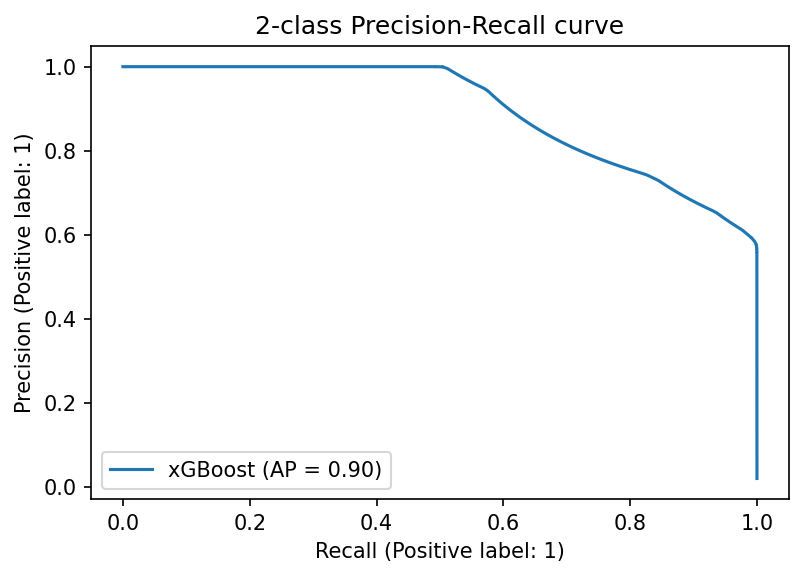

In [142]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, light_train[features], light_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Work on the Balanced Dataset

In [44]:
outage = light_train[light_train['power_outage']==True]
no_outage = light_train[light_train['power_outage']==False]
no_outage= no_outage.sample(n=3*len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [45]:
balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158296 entries, 2080128 to 1658115
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CENTERLON        158296 non-null  float64       
 1   CENTERLAT        158296 non-null  float64       
 2   TOTAL_COUNT      158296 non-null  int64         
 3   DATE             158296 non-null  datetime64[ns]
 4   county           158296 non-null  object        
 5   state            158296 non-null  object        
 6   power_outage     158296 non-null  bool          
 7   log_total_count  158296 non-null  float64       
 8   Month            158296 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 11.0+ MB


In [46]:
features = ['CENTERLON', 'CENTERLAT', 'log_total_count', 'Month']

In [47]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 16,  2),
    'n_estimators': range(100, 500, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)

In [48]:
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/home/painchess/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': range(1, 16, 2),
                         'n_estimators': range(100, 500, 40)},
             scoring='f1', verbose=True)

In [49]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [50]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 1, 100): 0.0,
 (0.01, 1, 140): 0.0,
 (0.01, 1, 180): 0.0,
 (0.01, 1, 220): 0.0,
 (0.01, 1, 260): 0.0,
 (0.01, 1, 300): 0.0,
 (0.01, 1, 340): 0.0,
 (0.01, 1, 380): 0.4765303851717809,
 (0.01, 1, 420): 0.47707877837421486,
 (0.01, 1, 460): 0.4778025499834393,
 (0.01, 3, 100): 0.5513286853625339,
 (0.01, 3, 140): 0.5967548220046444,
 (0.01, 3, 180): 0.6150658400337424,
 (0.01, 3, 220): 0.6223016932049033,
 (0.01, 3, 260): 0.6247301276975412,
 (0.01, 3, 300): 0.6261994117351053,
 (0.01, 3, 340): 0.628065099637196,
 (0.01, 3, 380): 0.6304139298277663,
 (0.01, 3, 420): 0.6308131389583826,
 (0.01, 3, 460): 0.6317235340012335,
 (0.01, 5, 100): 0.6148430457112651,
 (0.01, 5, 140): 0.6364700078110934,
 (0.01, 5, 180): 0.663963446018123,
 (0.01, 5, 220): 0.6721251834079072,
 (0.01, 5, 260): 0.7114563785561988,
 (0.01, 5, 300): 0.7141352525672536,
 (0.01, 5, 340): 0.7233300215700851,
 (0.01, 5, 380): 0.7272615743676011,
 (0.01, 5, 420): 0.7318742186337636,
 (0.01, 5, 460): 0.74410082870740

In [52]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=15,
    n_estimators=220) 

In [56]:
best_model.fit(balanced[features], balanced['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=220, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.9761712235306009
recall:  0.22620992534036014


In [ ]:
best_model.get_booster().get_score(importance_type='gain')

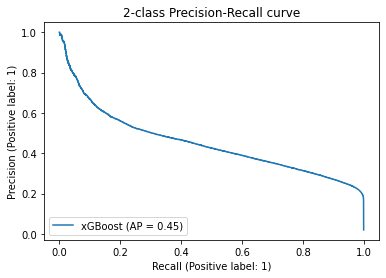

In [58]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, light_train[features], light_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Using multiple years of lightning

In [3]:
# Download them
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
lightning = [read_merged("lightning", year) for year in range(2015, 2024)]

/tmp/ipykernel_401727/3381521361.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_401727/3381521361.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_401727/3381521361.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_401727/3381521361.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_401727/3381521361.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
 

In [4]:
light = pd.concat(lightning)
del lightning

In [6]:
light.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23651698 entries, 0 to 2388298
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   #ZDAY         object 
 2   CENTERLON     float64
 3   CENTERLAT     float64
 4   TOTAL_COUNT   int64  
 5   DATE          object 
 6   county        object 
 7   state         object 
 8   Month         object 
 9   power_outage  bool   
 10  Event Month   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 2.0+ GB


In [5]:
del light['#ZDAY']
del light['Unnamed: 0']
light['log_total_count'] = np.log10(light['TOTAL_COUNT'])
light['DATE'] = pd.to_datetime(light['DATE'])
light['Month'] = light['DATE'].dt.month

In [12]:
light.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23651698 entries, 0 to 2388298
Data columns (total 10 columns):
 #   Column           Dtype         
---  ------           -----         
 0   CENTERLON        float64       
 1   CENTERLAT        float64       
 2   TOTAL_COUNT      int64         
 3   DATE             datetime64[ns]
 4   county           object        
 5   state            object        
 6   Month            int64         
 7   power_outage     bool          
 8   Event Month      object        
 9   log_total_count  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 1.8+ GB


In [13]:
light['power_outage'].value_counts(normalize=True)

False    0.987822
True     0.012178
Name: power_outage, dtype: float64

In [6]:
features = ['CENTERLON', 'CENTERLAT', 'log_total_count', 'Month', 'TOTAL_COUNT']

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer

In [8]:
light_train, light_test = train_test_split(light, test_size=0.2, stratify=light.power_outage)


In [9]:
light_tt, light_val = train_test_split(light_train, test_size=0.2, stratify=light_train.power_outage)

In [17]:
outage = light_tt[light_tt['power_outage']==True]
no_outage = light_tt[light_tt['power_outage']==False]
no_outage= no_outage.sample(n=4*len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [18]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    seed=42)

parameters = {
    'max_depth': range (5, 17,  2),
    'n_estimators': range(100, 400, 40),
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': range(5, 17, 2),
                         'n_estimators': range(100, 400, 40)},
             scoring='f1', verbose=True)

In [19]:
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 5, 100): 0.016605882167313245,
 (0.01, 5, 140): 0.016605790051764734,
 (0.01, 5, 180): 0.02361595505235175,
 (0.01, 5, 220): 0.17886048873670615,
 (0.01, 5, 260): 0.2359953673978048,
 (0.01, 5, 300): 0.2502994800081213,
 (0.01, 5, 340): 0.26495734415008854,
 (0.01, 5, 380): 0.27837217005596016,
 (0.01, 7, 100): 0.02896457992688678,
 (0.01, 7, 140): 0.12414344822448378,
 (0.01, 7, 180): 0.2873488427798051,
 (0.01, 7, 220): 0.3364969641838372,
 (0.01, 7, 260): 0.3531496846024763,
 (0.01, 7, 300): 0.3588592129889718,
 (0.01, 7, 340): 0.36517616904680555,
 (0.01, 7, 380): 0.37129379682653385,
 (0.01, 9, 100): 0.14664753875707826,
 (0.01, 9, 140): 0.2984301260628549,
 (0.01, 9, 180): 0.35017127699080286,
 (0.01, 9, 220): 0.3739505177637511,
 (0.01, 9, 260): 0.3960633478579511,
 (0.01, 9, 300): 0.4083668148620232,
 (0.01, 9, 340): 0.42068231961396163,
 (0.01, 9, 380): 0.43103616155759134,
 (0.01, 11, 100): 0.2520971367423045,
 (0.01, 11, 140): 0.3808075206854455,
 (0.01, 11, 180): 0.

In [21]:
prec = precision_score(best_model.predict(light_val[features]), light_val['power_outage'])
recall = recall_score(best_model.predict(light_val[features]), light_val['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.618465878268417
recall:  0.09378310969550596


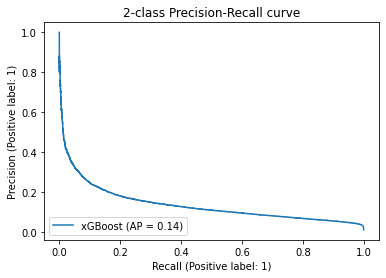

In [22]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, light_val[features], light_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")